# Набор тестов и проверок, что все правильно считается в неустойчивостях

In [1]:
from IPython.display import HTML
from IPython.display import Image
from PIL import Image as ImagePIL

%pylab
%matplotlib inline

Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib


Для случая бесконечного тонкого диска: $$\kappa=\frac{3}{R}\frac{d\Phi}{dR}+\frac{d^2\Phi}{dR^2}$$
где $\Phi$ - гравпотенциал, однако его знать не надо, т.к. есть проще формула: $$\kappa=\sqrt{2}\frac{\vartheta_c}{R}\sqrt{1+\frac{R}{\vartheta_c}\frac{d\vartheta_c}{dR}}$$

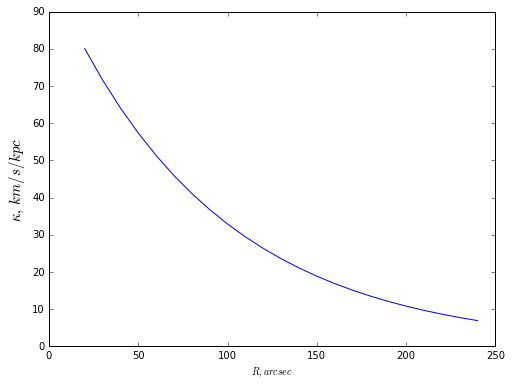

In [2]:
def model_kappa(R):
    return 100.*np.exp(-R/90.)

test_points = np.arange(20., 250., 10.)

fig = plt.figure(figsize=[8, 6])
plt.plot(test_points, model_kappa(test_points), '-')
plt.xlabel('$R, arcsec$')
plt.ylabel('$\kappa,\, km/s/kpc$', fontsize=15)
plt.show()

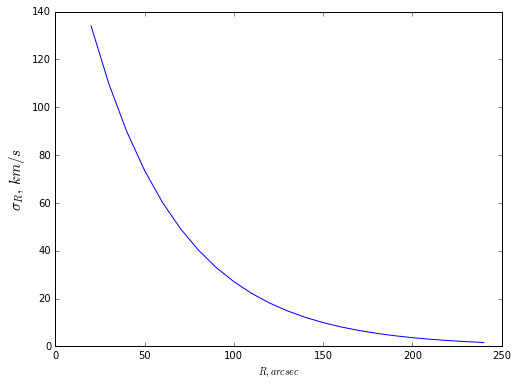

In [3]:
def model_sigmaR(R):
    return 200.*np.exp(-R/50.)

fig = plt.figure(figsize=[8, 6])
plt.plot(test_points, model_sigmaR(test_points), '-')
plt.xlabel('$R, arcsec$')
plt.ylabel('$\sigma_R,\, km/s$', fontsize=15)
plt.show()

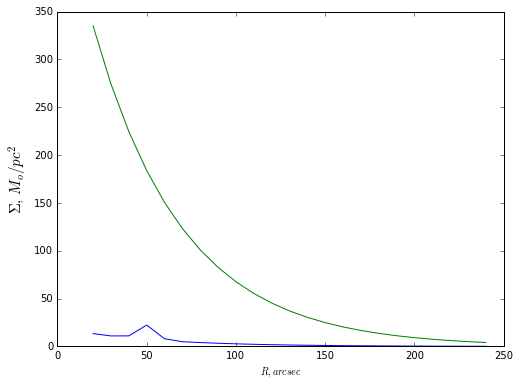

In [4]:
def model_star(R):
    return 500.*np.exp(-R/50.)

def model_gas(R):
    return 20.*np.exp(-R/50.) + 15.*np.exp(-(R-50.)**2/50.)

fig = plt.figure(figsize=[8, 6])
plt.plot(test_points, model_gas(test_points), '-')
plt.plot(test_points, model_star(test_points), '-')
plt.xlabel('$R, arcsec$')
plt.ylabel('$\Sigma,\, M_{o}/pc^2$', fontsize=15)
plt.show()

# Одножидкостный
Устойчиво, когда > 1:
$$Q_g = \frac{\Sigma_g^{cr}}{\Sigma_g}=\frac{\kappa c_g}{\pi G \Sigma_g}$$
$$Q_s = \frac{\Sigma_s^{cr}}{\Sigma_s}=\frac{\sigma_R}{\sigma_R^{min}}=\frac{\kappa \sigma_R}{3.36 G \Sigma_s}$$

In [5]:
G = 4.32 #гравитационная постоянная в нужных единицах
sound_vel = 6  #скорость звука в газе, км/с

def Qs(epicycl=None, sigma=None, star_density=None):
    '''Вычисление безразмерного параметра Тумре для звездного диска. 
    Зависит от плотности звезд, дисперсии скоростей и эпициклической частоты.'''
    return epicycl * sigma / (3.36 * G * star_density)


def Qg(epicycl=None, sound_vel=None, gas_density=None):
    '''Вычисление безразмерного параметра Тумре для газового диска. 
    Зависит от плотности газа и эпициклической частоты, скорости звука в газе.'''
    return epicycl * sound_vel / (math.pi * G * gas_density)

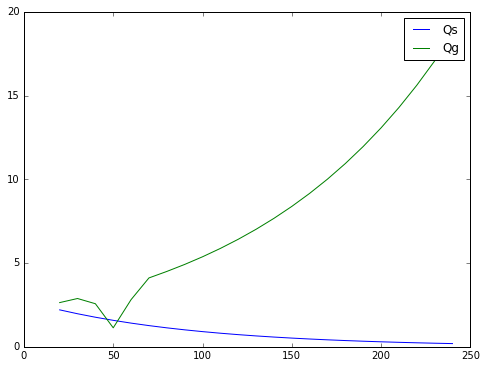

In [6]:
fig = plt.figure(figsize=[8, 6])
plt.plot(test_points, [Qs(epicycl=epicycl, sigma=sigma, star_density=star_density) for (epicycl, sigma, star_density) in zip(
        model_kappa(test_points), model_sigmaR(test_points), model_star(test_points))], label='Qs')
plt.plot(test_points, [Qg(epicycl=epicycl, sound_vel=sound_vel_, gas_density=gas_density) for 
                       (epicycl, sound_vel_, gas_density) in zip(model_kappa(test_points), 
                                                                 [sound_vel]*len(test_points), 
                                                                 model_gas(test_points))], label='Qg')
plt.legend()
plt.show()

# Двухжидкостная:

Кинетическое приближение:
$$\frac{1}{Q_{\mathrm{eff}}}=\frac{2}{Q_{\mathrm{s}}}\frac{1}{\bar{k}}\left[1-e^{-\bar{k}^{2}}I_{0}(\bar{k}^{2})\right]+\frac{2}{Q_{\mathrm{g}}}s\frac{\bar{k}}{1+\bar{k}^{2}s^{2}}>1\,$$

Гидродинамическое приближение:
$$\frac{2\,\pi\, G\, k\,\Sigma_{\mathrm{s}}}{\kappa+k^{2}\sigma_{\mathrm{s}}}+\frac{2\,\pi\, G\, k\,\Sigma_{\mathrm{g}}}{\kappa+k^{2}c_{\mathrm{g}}}>1$$ или $$\frac{1}{Q_{\mathrm{eff}}}=\frac{2}{Q_{\mathrm{s}}}\frac{\bar{k}}{1+\bar{k}^{2}}+\frac{2}{Q_{\mathrm{g}}}s\frac{\bar{k}}{1+\bar{k}^{2}s^{2}}>1$$ для безразмерного волнового числа ${\displaystyle \bar{k}\equiv\frac{k\,\sigma_{\mathrm{s}}}{\kappa}},\, s=c/\sigma$

In [7]:
from scipy.special import i0e, i1e

def inverse_hydro_Qeff_from_k(dimlK, Qg=None, Qs=None, s=None):
    return 2.*dimlK / Qs / (1 + dimlK**2) + 2*s*dimlK / Qg / (1 + dimlK**2 * s**2)

def inverse_kinem_Qeff_from_k(dimlK, Qg=None, Qs=None, s=None):
    return 2. / dimlK / Qs * (1 - i0e(dimlK ** 2)) + 2*s*dimlK / Qg / (1 + dimlK**2 * s**2)

<div class="alert alert-success">
    <h3> ✓Test:</h3>
</div>
проверим, что на каком-то участке значения совпадают

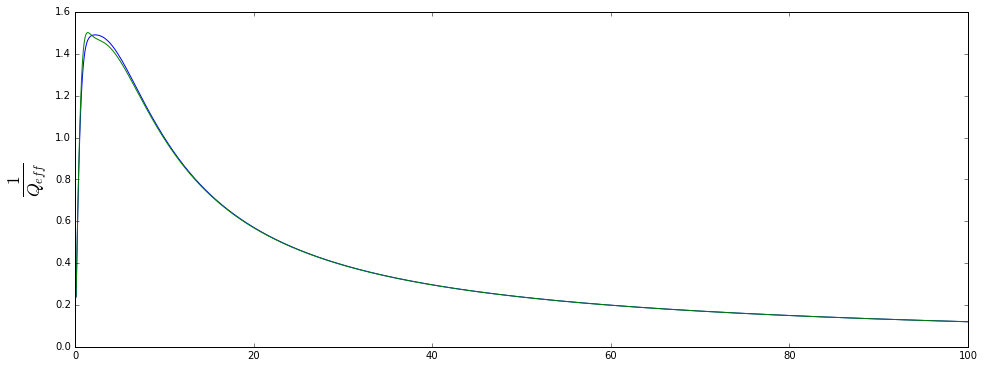

In [8]:
fig = plt.figure(figsize=[16, 6])
pp_ = np.linspace(0.1, 100., 1000)
plt.plot(pp_, [inverse_hydro_Qeff_from_k(l, Qg=1., Qs=1., s=0.2) for l in pp_], '-')
plt.plot(pp_, [inverse_kinem_Qeff_from_k(l, Qg=1., Qs=1., s=0.2) for l in pp_], '-')
plt.ylabel(r'$\frac{1}{Q_{eff}}$', fontsize=25)
plt.show()

Видно, что различия есть (как и показывал Rafikov), но с хорошей точностью значения совпадают.

Зависимость от величины параметров:

In [9]:
inv_qss = np.arange(0.01, 1.2, 0.1)
inv_qgs = np.arange(0.01, 1.2, 0.1)

inv_qeffs = []

for qg in inv_qgs:
    for qs in inv_qss:
        inv_qeff = max([inverse_kinem_Qeff_from_k(l, Qg=1./qg, Qs=1./qs, s=0.2) for l in np.arange(0.1, 10000., 1.0)])
        inv_qeffs.append(inv_qeff)

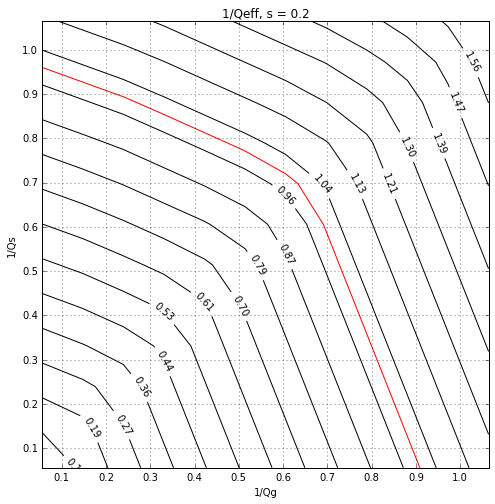

In [10]:
fig = plt.figure(figsize=[8, 8])

ax1 = fig.add_subplot(111)
qeffs = np.array(inv_qeffs).reshape(len(inv_qgs), len(inv_qgs))
levels = np.linspace(qeffs.min(), qeffs.max(), 20)

cset=ax1.contour(qeffs, levels, hold='on', colors = 'k', origin='lower', extent=[inv_qgs[0],inv_qgs[-1],inv_qss[0],inv_qss[-1]])
ax1.clabel(cset, inline=1, fontsize=10, fmt='%1.2f')
ax1.grid()
ax1.set_xlabel('1/Qg')
ax1.set_ylabel('1/Qs')
ax1.set_title('1/Qeff, s = 0.2')
ax1.set_xticks(np.arange(0, 1.1, 0.1))
ax1.set_yticks(np.arange(0, 1.1, 0.1))

levels = np.array([1.0])
cset=ax1.contour(qeffs, levels, hold='on', colors = 'r', origin='lower', extent=[inv_qgs[0],inv_qgs[-1],inv_qss[0],inv_qss[-1]])

plt.show()

<div class="alert alert-success">
    <h3> ✓Test:</h3>
</div>воспроизвести следующую иллюстрацию из Rafikov 2001 (Fig.3)

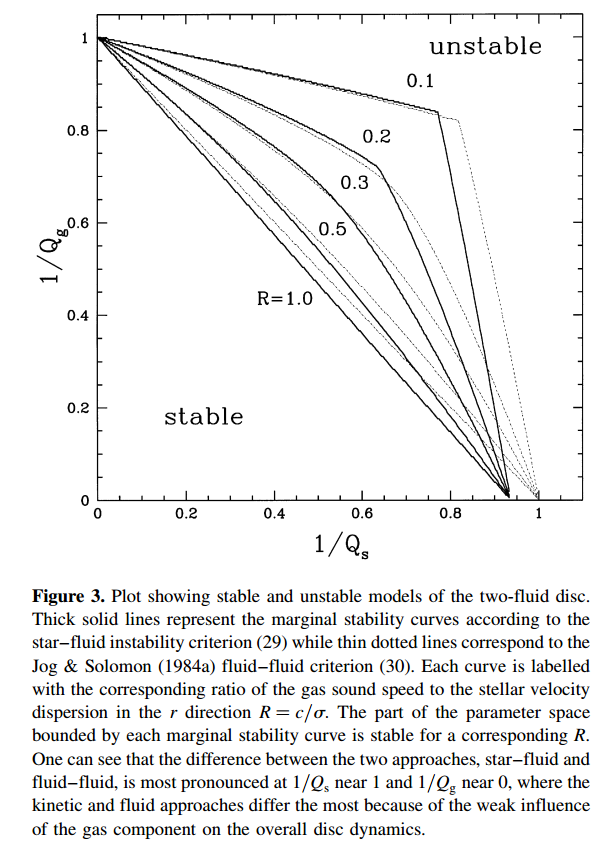

In [11]:
Image('rafikov_fig3.png')

In [12]:
inv_qss = np.arange(0.01, 1.2, 0.1)
inv_qgs = np.arange(0.01, 1.2, 0.1)

s_params = [1.0, 0.5, 0.3, 0.2, 0.1]
inv_qeffs_k = [[],[],[],[],[]]
inv_qeffs_h = [[],[],[],[],[]]

for ind, s in enumerate(s_params):
    for qg in inv_qgs:
        for qs in inv_qss:
            inv_qeff = max([inverse_kinem_Qeff_from_k(l, Qg=1./qg, Qs=1./qs, s=s) for l in np.arange(0.1, 10000., 1.0)])
            inv_qeffs_k[ind].append(inv_qeff)
            inv_qeff = max([inverse_hydro_Qeff_from_k(l, Qg=1./qg, Qs=1./qs, s=s) for l in np.arange(0.1, 10000., 1.0)])
            inv_qeffs_h[ind].append(inv_qeff)

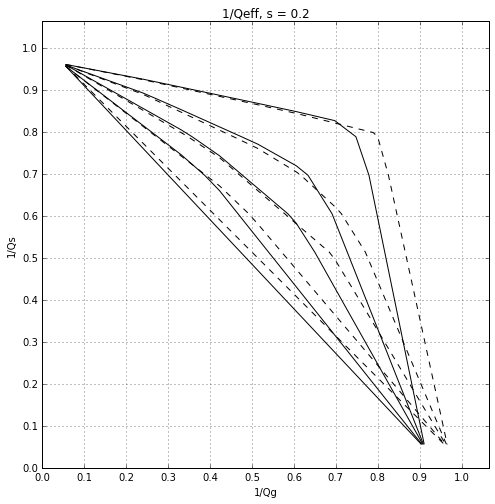

In [13]:
fig = plt.figure(figsize=[8, 8])

ax1 = fig.add_subplot(111)
levels = np.array([1.])

for ind, s in enumerate(s_params):
    qeffs = np.array(inv_qeffs_h[ind]).reshape(len(inv_qgs), len(inv_qgs))
    cset=ax1.contour(qeffs, levels, hold='on', colors = 'k', origin='lower', 
                     extent=[inv_qgs[0],inv_qgs[-1],inv_qss[0],inv_qss[-1]], linestyles='dashed')
    qeffs = np.array(inv_qeffs_k[ind]).reshape(len(inv_qgs), len(inv_qgs))
    cset=ax1.contour(qeffs, levels, hold='on', colors = 'k', origin='lower', 
                     extent=[inv_qgs[0],inv_qgs[-1],inv_qss[0],inv_qss[-1]])
ax1.grid()
ax1.set_xlabel('1/Qg')
ax1.set_ylabel('1/Qs')
ax1.set_title('1/Qeff, s = 0.2')
ax1.set_xticks(np.arange(0, 1.1, 0.1))
ax1.set_yticks(np.arange(0, 1.1, 0.1))

plt.show()

Успешно!

# Нахождение максимума функции:

В гидродинамическом приближении вообще просто - это многочлен
$$\frac{2}{Q_{\mathrm{s}}}\frac{\bar{k}}{1+\bar{k}^{2}}+\frac{2}{Q_{\mathrm{g}}}s\frac{\bar{k}}{1+\bar{k}^{2}s^{2}}>1$$
и у него можно найти максимум методами Sympy, взяв производную:

In [14]:
from sympy import *
x = Symbol('x', real=True)
a = 1.5
f = 2./a*x/(1+x**2) + 2/0.9*0.4*x/(1+x**2 * 0.4**2)
roots = solve(f.diff(), x)
print roots
print max([f.evalf(subs={x:r}) for r in roots])

[-1.85855358154608, 1.85855358154608]
1.62034285003827


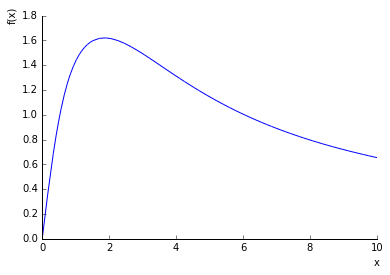

In [15]:
from sympy.plotting import plot
plot(f, (x, 0., 10.))

In [16]:
def findInvHydroQeffSympy(Qs, Qg, s):
    '''Решаем уравнение deriv()=0 чтобы найти максимум функции в гидродинамическом приближении.'''
    k = Symbol('k') #solve for complex because it may returns roots as 1.03957287978471 + 0.e-20*I 
    foo = 2./Qs*k/(1+k**2) + 2/Qg*s*k/(1+k**2 * s**2)
    foo2 = 2./Qs * (1-k)*(1+k * s**2)**2 + 2/Qg*s*(1-k*s**2)*(1+k)**2
    roots = solve(foo2.simplify(), k)
    roots = [np.sqrt(float(abs(re(r)))) for r in roots]
    _tmp = [foo.evalf(subs={k:r}) for r in roots]
    max_val = max(_tmp)
    return (roots[_tmp.index(max_val)], max_val)

In [17]:
findInvHydroQeffSympy(1.32, 1.22, 0.52)

(1.408446000988677, 1.49668341702704)

Второй метод - тупо перебор по сетке:

In [18]:
def findInvHydroQeffBrute(Qs, Qg, s, krange):
    '''Находим максимум функции в гидродинамическом приближении перебором по сетке.'''
    _tmp = [inverse_hydro_Qeff_from_k(l, Qg=Qg, Qs=Qs, s=s) for l in krange]
    max_val = max(_tmp)
    root_for_max = krange[_tmp.index(max_val)]
    if abs(root_for_max-krange[-1]) < 0.5:
        print 'WARNING! For Qs={} Qg={} s={} root of max near the max of k-range'.format(Qs, Qg, s)
    return (root_for_max, max_val)

In [19]:
findInvHydroQeffBrute(1.32, 1.22, 0.52, np.arange(0.01, 300., 0.01))

(1.4100000000000001, 1.4966826880822235)

Последний метод - используя производную, запускать brentq на нужном промежутке:

In [20]:
from scipy.optimize import brentq

def findInvHydroQeffBrentq(Qs, Qg, s, krange):
    '''Решение уравнения deriv(9) = 0 для нахождения максимума исходной функции. Запускается brentq на исходной сетке,
    в случае если на концах сетки разные знаки функции (промежуток содержит корень),
    затем выбираются лучшие корни, после чего ищется, какой их них дает максимум. Возвращается только этот корень.'''
    grid = krange
    args = [Qs, Qg, s]
    signs = [derivTwoFluidHydroQeff(x, *args) for x in grid]
    signs = map(lambda x: x / abs(x), signs)
    roots = []
    for i in range(0, signs.__len__() - 1):
        if signs[i] * signs[i + 1] < 0:
            roots.append(brentq(lambda x: derivTwoFluidHydroQeff(x, *args), grid[i], grid[i + 1]))
    original = [inverse_hydro_Qeff_from_k(l, Qg=Qg, Qs=Qs, s=s) for l in roots]
    root_for_max = roots[original.index(max(original))]
    if abs(root_for_max-krange[-1]) < 0.5:
        print 'WARNING! For Qs={} Qg={} s={} root of max near the max of k-range'.format(Qs, Qg, s)
    return (root_for_max, max(original))

def derivTwoFluidHydroQeff(dimlK, Qs, Qg, s):
    '''Производная по \bar{k} от левой части (9) для того, чтобы найти максимум.'''
    part1 = (1 - dimlK ** 2) / (1 + dimlK ** 2) ** 2
    part3 = (1 - (dimlK * s) ** 2) / (1 + (dimlK * s) ** 2) ** 2
    return (2 * part1 / Qs) + (2 * s * part3 / Qg)

In [21]:
findInvHydroQeffBrentq(1.32, 1.22, 0.52, np.arange(0.01, 300., 0.01))

(1.4084460009886812, 1.496683417027044)

<div class="alert alert-success">
    <h3> ✓Test:</h3>
</div>
все три метода должны работать и давать почти одинаковые результаты на случайных данных.  

In [22]:
cases_n = 1000
test_cases = zip(np.random.uniform(0.01, 3., cases_n), 
                 np.random.uniform(0.01, 3., cases_n), 
                 np.abs(np.random.normal(0.01, 0.5, cases_n)))

In [23]:
test_cases[0:10]

[(1.3987162174377841, 1.8833493799981211, 0.043122224912887336),
 (2.9636536441180037, 1.1259335411853346, 0.1867798657750013),
 (0.45599899133076466, 2.9528636061756224, 0.048462964564895107),
 (2.125400508827596, 2.3728461635931799, 0.084872540865969001),
 (2.5437677554102147, 0.83478689497367764, 0.73158943302336177),
 (2.5342236331740797, 1.1847886790880748, 0.48648433974323502),
 (0.74990635804642491, 1.2711390425712341, 0.36769185780156771),
 (1.9284655553546435, 2.921070683951235, 0.23615294447386503),
 (2.0707616396622135, 0.82385816411630208, 0.30673580599697481),
 (0.35396922792227303, 2.8660673836034158, 0.15756006412849624)]

In [24]:
%time bren = [findInvHydroQeffBrentq(case[0], case[1], case[2], np.arange(0.01, 60000., 1.)) for case in test_cases]

Wall time: 4min 55s


In [25]:
%time sym = [findInvHydroQeffSympy(case[0], case[1], case[2]) for case in test_cases]

Wall time: 8min 4s


In [26]:
%time bru = [findInvHydroQeffBrute(case[0], case[1], case[2], np.arange(0.01, 3000., 0.01)) for case in test_cases]

WARNING! For Qs=2.14959647284 Qg=0.156378326472 s=7.13508746236e-05 root of max near the max of k-range
Wall time: 14min 1s


In [27]:
%time bru = [findInvHydroQeffBrute(c[0], c[1], c[2], np.arange(b[0]-100., b[0]+100., 0.001)) for c, b in zip(test_cases, bren)]

Wall time: 9min 17s


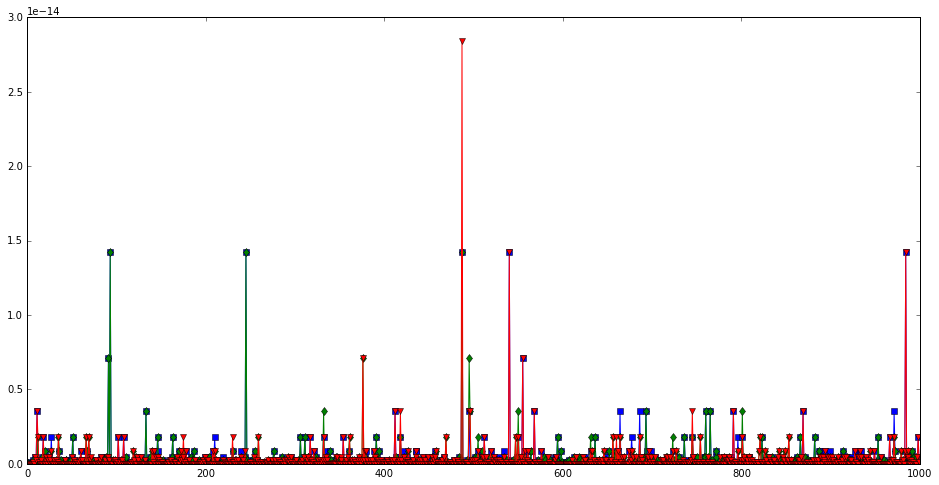

In [28]:
fig = plt.figure(figsize=[16, 8])
plt.plot(range(cases_n), abs(np.array(zip(*bren)[1])-np.array(zip(*bru)[1])), 's-')
plt.plot(range(cases_n), abs(np.array(zip(*bren)[1])-np.array(zip(*sym)[1])), 'd-')
plt.plot(range(cases_n), abs(np.array(zip(*sym)[1])-np.array(zip(*bru)[1])), 'v-')
plt.show()

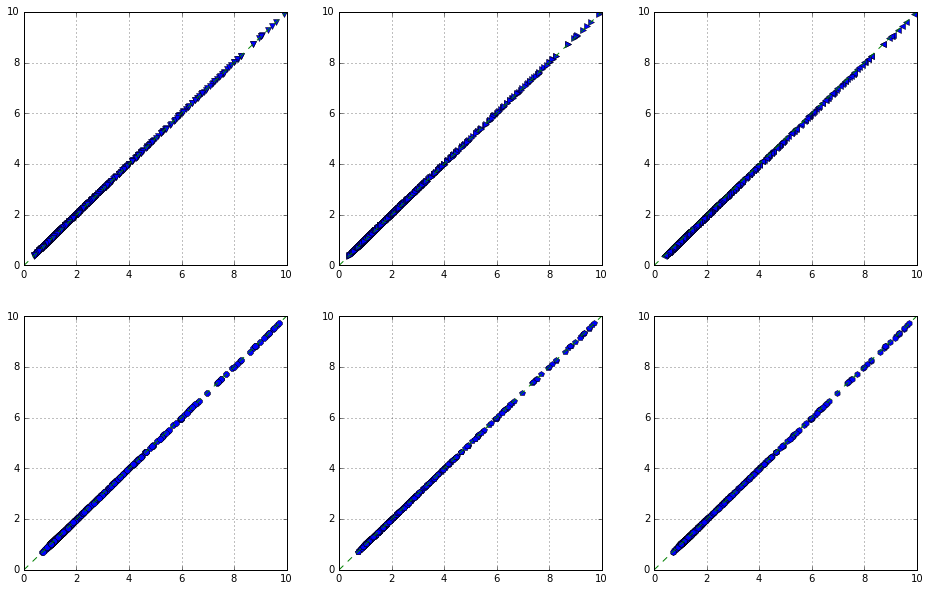

In [29]:
fig, axes = plt.subplots(2, 3, figsize=[16, 10])
axes[0][0].plot(zip(*sym)[1], zip(*bru)[1], 'v')
axes[0][1].plot(zip(*sym)[1], zip(*bren)[1], '>')
axes[0][2].plot(zip(*bren)[1], zip(*bru)[1], '<')

axes[1][0].plot(zip(*sym)[0], zip(*bru)[0], '8')
axes[1][1].plot(zip(*sym)[0], zip(*bren)[0], 'p')
axes[1][2].plot(zip(*bren)[0], zip(*bru)[0], 'h')

for ax in axes:
    for a in ax:
        a.set_xlim(0., 10.)
        a.set_ylim(0., 10.)
        a.grid()
        a.plot([0,10], [0, 10], '--')
plt.show()

Внешнее согласие отличное.

Теперь кинематическое приближение:
$$\frac{2}{Q_{\mathrm{s}}}\frac{1}{\bar{k}}\left[1-e^{-\bar{k}^{2}}I_{0}(\bar{k}^{2})\right]+\frac{2}{Q_{\mathrm{g}}}s\frac{\bar{k}}{1+\bar{k}^{2}s^{2}}>1\,$$
Тут сложнее, честно уже не решить. остается два способа - брутфорсом и brentq, производная известна.

In [30]:
def findInvKinemQeffBrute(Qs, Qg, s, krange):
    '''Находим максимум функции в кинематическом приближении перебором по сетке.'''
    _tmp = [inverse_kinem_Qeff_from_k(l, Qg=Qg, Qs=Qs, s=s) for l in krange]
    max_val = max(_tmp)
    root_for_max = krange[_tmp.index(max_val)]
    if abs(root_for_max-krange[-1]) < 0.5:
        print 'WARNING! For Qs={} Qg={} s={} root of max near the max of k-range'.format(Qs, Qg, s)
    return (root_for_max, max_val)

In [31]:
findInvKinemQeffBrute(1.32, 1.22, 0.52, np.arange(0.01, 300., 0.01))

(1.3, 1.5278157625496003)

In [32]:
def findInvKinemQeffBrentq(Qs, Qg, s, krange):
    '''Решение уравнения deriv(13) = 0 для нахождения максимума исходной функции. Запускается brentq на исходной сетке,
    в случае если на концах сетки разные знаки функции (промежуток содержит корень),
    затем выбираются лучшие корни, после чего ищется, какой их них дает максимум. Возвращается только этот корень.'''
    grid = krange
    args = [Qs, Qg, s]
    signs = [derivTwoFluidKinemQeff(x, *args) for x in grid]
    signs = map(lambda x: x / abs(x), signs)
    roots = []
    for i in range(0, signs.__len__() - 1):
        if signs[i] * signs[i + 1] < 0:
            roots.append(brentq(lambda x: derivTwoFluidKinemQeff(x, *args), grid[i], grid[i + 1]))
    original = [inverse_kinem_Qeff_from_k(l, Qg=Qg, Qs=Qs, s=s) for l in roots]
    root_for_max = roots[original.index(max(original))]
    if abs(root_for_max-krange[-1]) < 0.5:
        print 'WARNING! For Qs={} Qg={} s={} root of max near the max of k-range'.format(Qs, Qg, s)
    return (root_for_max, max(original))


def derivTwoFluidKinemQeff(dimlK, Qs, Qg, s):
    '''Производная по \bar{k} от левой части (13) для того, чтобы найти максимум. Коррекция за ассимптотику производится
    с помощью встроенных функций бесселя, нормированных на exp.'''
    part1 = (1 - i0e(dimlK ** 2)) / (-dimlK ** 2)
    part2 = (2 * dimlK * i0e(dimlK ** 2) - 2 * dimlK * i1e(dimlK ** 2)) / dimlK
    part3 = (1 - (dimlK * s) ** 2) / (1 + (dimlK * s) ** 2) ** 2
    return 2 * (part1 + part2) / Qs + 2 * s * part3 / Qg

In [33]:
findInvKinemQeffBrentq(1.32, 1.22, 0.52, np.arange(0.01, 300., 0.01))

(1.3012816962470588, 1.5278164121945141)

<div class="alert alert-success">
    <h3> ✓Test:</h3>
</div>оба метода должны давать схожие величины и работать в принципе

In [34]:
cases_n = 1000
test_cases = zip(np.random.uniform(0.01, 3., cases_n), 
                 np.random.uniform(0.01, 3., cases_n), 
                 np.abs(np.random.normal(0.01, 0.5, cases_n)))

In [35]:
test_cases[0:10]

[(0.67357165292058629, 2.1786207344508108, 0.90952694282240876),
 (0.99568228051811858, 0.27051485012602783, 0.46954801516329681),
 (0.75827623584232695, 1.5983523646144933, 0.63550270149372023),
 (2.3152258999722792, 1.7869210578137114, 0.28869607059323604),
 (1.6478476239288122, 0.43559991766515382, 0.32851829639785596),
 (1.609325285303828, 1.7300272167357589, 0.89429059519364429),
 (0.089296122925659555, 2.6407472127551554, 1.0039925833314838),
 (2.3606166960172561, 2.2560953378229063, 0.31568410818279175),
 (0.43192076382276579, 1.8497297243985291, 0.76797125767432284),
 (1.1610558706639045, 0.65118168481894056, 0.92418204454805497)]

In [36]:
%time bren = [findInvKinemQeffBrentq(case[0], case[1], case[2], np.arange(0.01, 60000., 1.)) for case in test_cases]

Wall time: 9min 17s


In [37]:
%time bru = [findInvKinemQeffBrute(case[0], case[1], case[2], np.arange(0.01, 3000., 0.01)) for case in test_cases]

Wall time: 20min 11s


In [38]:
%time bru = [findInvKinemQeffBrute(c[0], c[1], c[2], np.arange(b[0]-100., b[0]+100., 0.001)) for c, b in zip(test_cases, bren)]

Wall time: 12min 57s


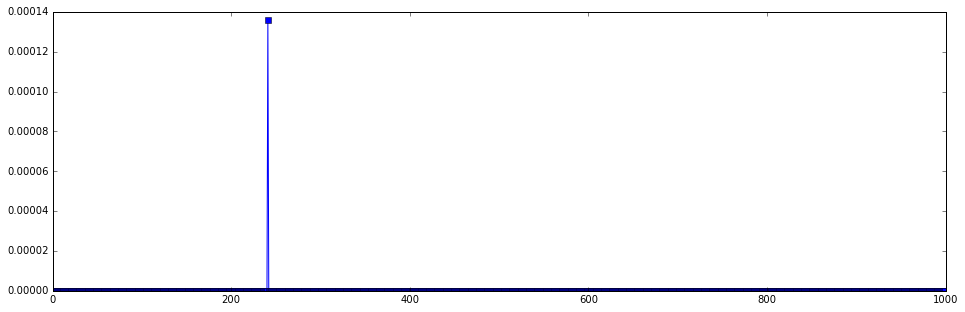

In [39]:
fig = plt.figure(figsize=[16, 5])
plt.plot(range(cases_n), abs(np.array(zip(*bren)[1])-np.array(zip(*bru)[1])), 's-')
plt.show()

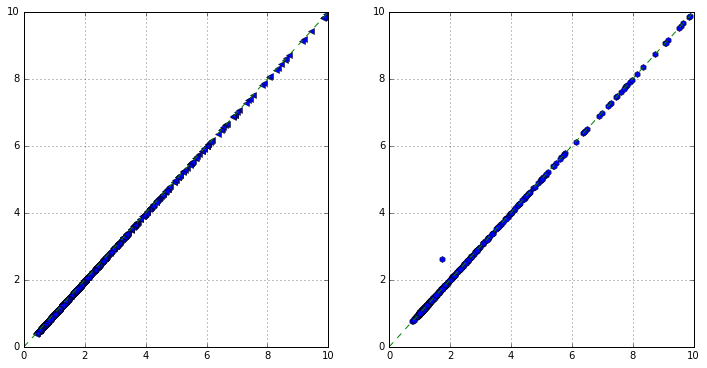

In [40]:
fig, axes = plt.subplots(1, 2, figsize=[12, 6])
axes[0].plot(zip(*bren)[1], zip(*bru)[1], '<')
axes[1].plot(zip(*bren)[0], zip(*bru)[0], 'h')

for ax in axes:
    ax.set_xlim(0., 10.)
    ax.set_ylim(0., 10.)
    ax.grid()
    ax.plot([0,10], [0, 10], '--')
plt.show()

Работает

<div class="alert alert-success">
    <h3> ✓Test:</h3>
</div>Кинематические решения должны быть не очень далеко от гидродинамических - Kinem ~ Hydro 

In [41]:
cases_n = 200
test_cases = zip(np.random.uniform(0.01, 3., cases_n), 
                 np.random.uniform(0.01, 3., cases_n), 
                 np.abs(np.random.normal(0.01, 0.5, cases_n)))

In [42]:
test_cases[0:10]

[(1.7444851082162838, 1.3194676487109918, 0.011506433196963758),
 (0.57234597266808884, 2.9134177440260514, 1.0755333896988353),
 (0.31396063973310034, 2.3299853455841828, 0.049036909955103826),
 (2.7067652477026036, 0.70965794888446809, 0.47260927982727263),
 (1.3893629501806681, 2.6359308634216534, 0.71683131813870293),
 (2.8039093467157814, 0.035653250254213592, 0.075662637899092125),
 (2.0491515646982483, 1.7381883725327276, 0.26035606253080623),
 (1.0682433112312681, 1.5429775920498221, 0.41180466241979941),
 (0.38940957862329906, 1.2142398772269165, 0.016955058310928771),
 (2.3736586281140126, 2.1299153350325097, 0.18761106821520862)]

In [43]:
%time kin = [findInvKinemQeffBrentq(case[0], case[1], case[2], np.arange(0.01, 60000., 1.)) for case in test_cases]

Wall time: 1min 45s


In [44]:
%time hyd = [findInvHydroQeffBrentq(case[0], case[1], case[2], np.arange(0.01, 60000., 1.)) for case in test_cases]

Wall time: 53.2 s


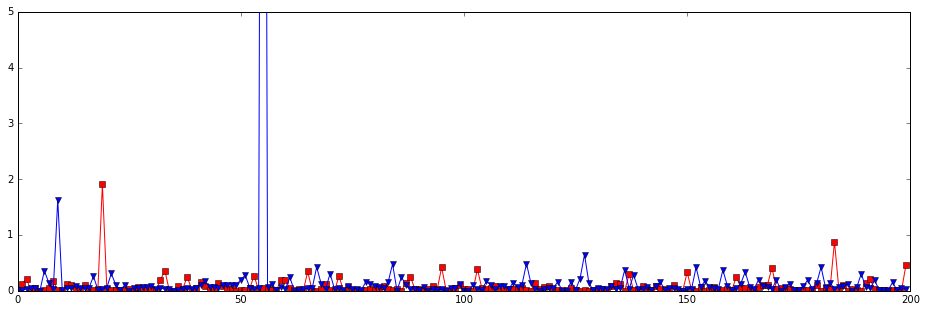

In [45]:
fig = plt.figure(figsize=[16, 5])
plt.plot(range(cases_n), abs(np.array(zip(*kin)[1])-np.array(zip(*hyd)[1])), 's-', color='red')
plt.plot(range(cases_n), abs(np.array(zip(*kin)[0])-np.array(zip(*hyd)[0])), 'v-')
plt.ylim(0, 5.)
plt.show()

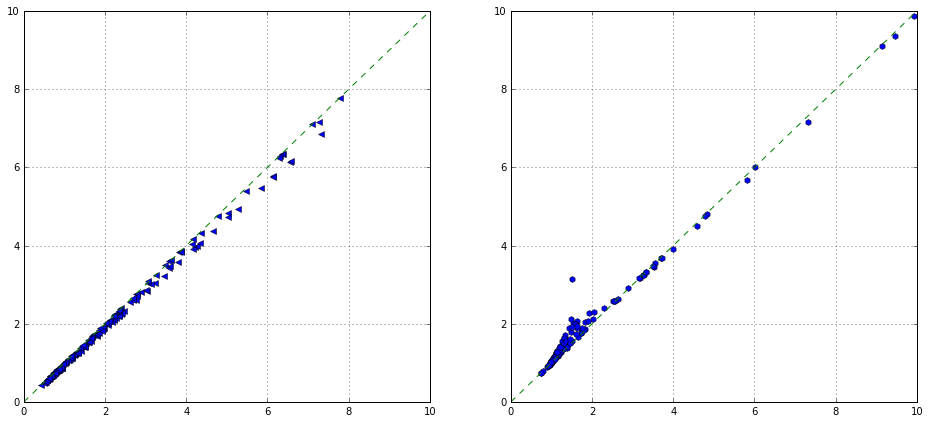

In [46]:
fig, axes = plt.subplots(1, 2, figsize=[16, 7])
axes[0].plot(zip(*kin)[1], zip(*hyd)[1], '<')
axes[1].plot(zip(*kin)[0], zip(*hyd)[0], 'h')

for ax in axes:
    ax.set_xlim(0., 10.)
    ax.set_ylim(0., 10.)
    ax.grid()
    ax.plot([0,10], [0, 10], '--')
plt.show()

Видно, что максимум иногда съезжает и Q иногда различается, но в целом все достаточно близко.

<div class="alert alert-success">
    <h3> ✓Test:</h3>
</div>
$$Q_{2F} \le Q_{1F}$$

In [47]:
# используем сосчитанные выше кейсы
%time qgs = [1./case[1] for case in test_cases]

Wall time: 0 ns


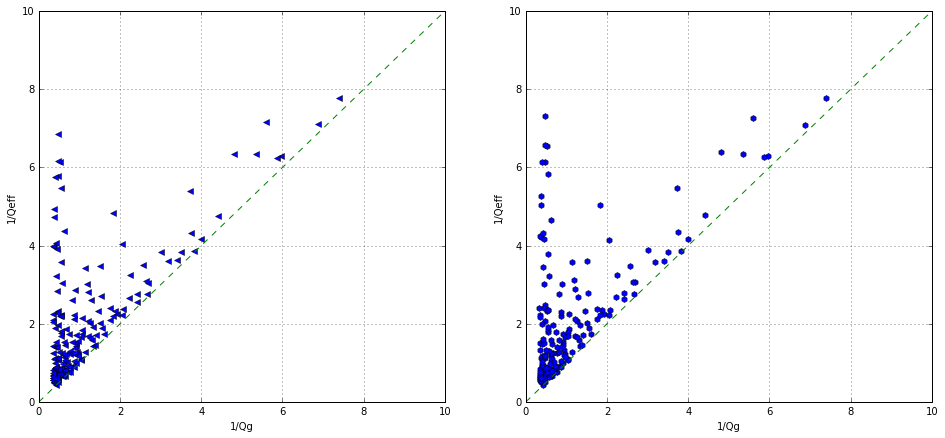

In [48]:
fig, axes = plt.subplots(1, 2, figsize=[16, 7])
axes[0].plot(qgs, zip(*hyd)[1], '<')
axes[1].plot(qgs, zip(*kin)[1], 'h')

for ax in axes:
    ax.set_xlim(0., 10.)
    ax.set_ylim(0., 10.)
    ax.grid()
    ax.plot([0,10], [0, 10], '--')
    ax.set_xlabel('1/Qg')
    ax.set_ylabel('1/Qeff')
plt.show()

Верно

<div class="alert alert-success">
    <h3> ✓Test:</h3>
</div>
воспроизвести график из следующей иллюстрации Rafikov 2001

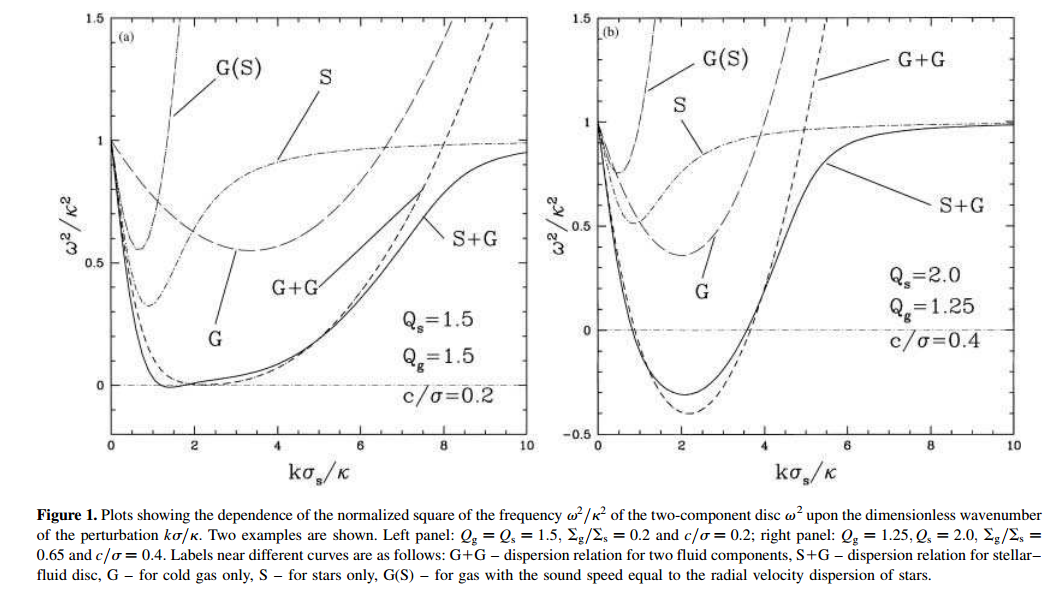

In [49]:
Image('rafikov_fig1.png')

Не слишком полезно с общей точки зрения (т.к. зависимость немого отличается), но показательно. 
Зависимости от квадрата возмущения следующие (видоизменненое уравнение 22 в оригинальной статье):
$$\frac{2}{Q_{\mathrm{s}}}\frac{1}{\bar{k}}\left[1-e^{-\bar{k}^{2}}I_{0}(\bar{k}^{2})\right]\frac{1}{1 - \omega^2/\kappa^2}+\frac{2}{Q_{\mathrm{g}}}s\frac{\bar{k}}{1+\bar{k}^{2}s^{2} - \omega^2/\kappa^2}=1\,$$
для газа: $$\bar{k}^2s^2 + 1 - \frac{2}{Q_{\mathrm{g}}}s\bar{k} = \omega^2/\kappa^2$$
для звезд: $$1 - \frac{2}{Q_{\mathrm{s}}}\frac{1}{\bar{k}}\left[1-e^{-\bar{k}^{2}}I_{0}(\bar{k}^{2})\right] = \omega^2/\kappa^2$$

In [50]:
from scipy.special import i0e, i1e
from scipy.optimize import fsolve

qg = 1.5
qs = 1.5
s = 0.2

tp = np.arange(0.1, 10., 0.1)

def twofl_w2(l):
    global qg, qs, s, dimlK
    return 2. / dimlK / qs * (1 - i0e(dimlK ** 2)) * (1. / (1 - l)) + 2*s*dimlK / qg / (1 + dimlK**2 * s**2 - l) - 1.

sol = []
for d in tp:
    dimlK = d
    initial_guess = 0.
    solution = fsolve(twofl_w2, initial_guess)
    sol.append(solution)

def star_w2(qs, dimlK):
    return 1. - 2. / dimlK / qs * (1 - i0e(dimlK ** 2))

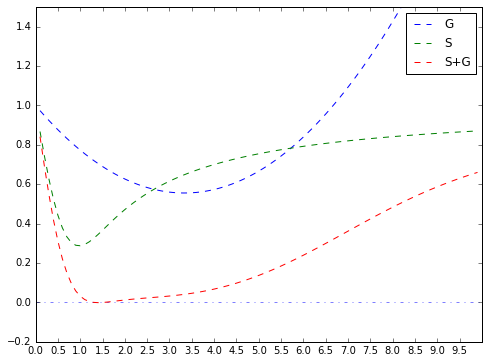

In [51]:
cold_gas = lambda l: l**2 * s**2 + 1. - 2./qg * s * l

fig = plt.figure(figsize=[8, 6])
plt.axhline(y=0, ls='-.', alpha=0.5)
plt.plot(tp, map(cold_gas, tp), '--', label='G')
plt.plot(tp, [star_w2(1.5, x) for x in tp], '--', label='S')
plt.plot(tp, sol, '--', label='S+G')
plt.xlim(0, 10)
plt.ylim(-0.2, 1.5)
plt.legend()
plt.xticks(np.arange(0, 10, 0.5))
plt.show()

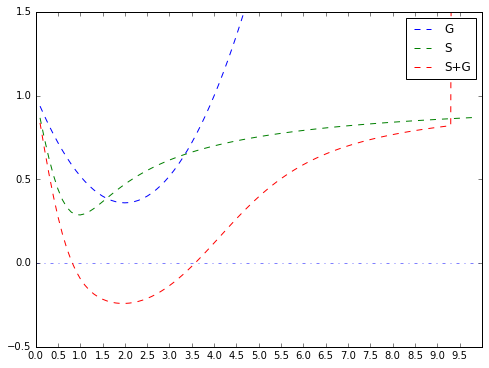

In [52]:
qg = 1.25
qs = 2.0
s = 0.4

sol = []
for d in tp:
    dimlK = d
    initial_guess = 0.
    solution = fsolve(twofl_w2, initial_guess)
    sol.append(solution)
    
fig = plt.figure(figsize=[8, 6])
plt.axhline(y=0, ls='-.', alpha=0.5)
plt.plot(tp, map(cold_gas, tp), '--', label='G')
plt.plot(tp, [star_w2(1.5, x) for x in tp], '--', label='S')
plt.plot(tp, sol, '--', label='S+G')
plt.xlim(0, 10)
plt.ylim(-0.5, 1.5)
plt.legend()
plt.xticks(np.arange(0, 10, 0.5))
plt.show()

Все похоже

<div class="alert alert-danger">
    <h3> Test:</h3>
</div>повторить 1F и 2F для NGC7217

сложность - где взять $\Sigma_s$?

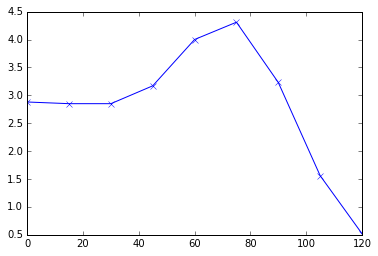

In [53]:
data_path = '../../data/ngc7217'
r_g_dens, gas_dens = zip(*np.loadtxt(data_path + "/gas_density.dat", float))
plt.plot(r_g_dens, gas_dens, 'x-')

(0, 250)

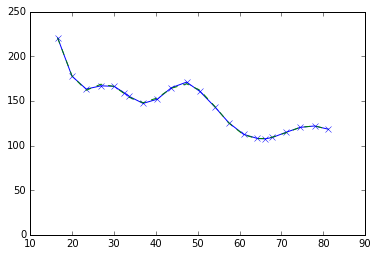

In [54]:
r_sig, sigR = zip(*np.loadtxt(data_path + "/silchenko_sigR.dat", float, delimiter=','))
poly_sig = poly1d(polyfit(r_sig, sigR, deg=11))
plt.plot(r_sig, sigR, 'x-')
plt.plot(r_sig, poly_sig(r_sig), '--')
plt.ylim(0, 250)

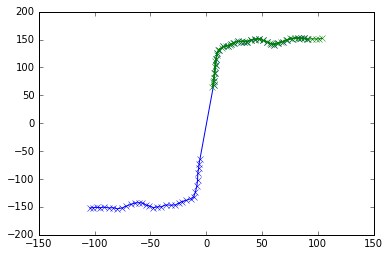

In [55]:
r_v, vel = zip(*np.loadtxt(data_path + "/silchenko_vel_g_approx.dat", float, delimiter=','))
plt.plot(r_v, vel, 'x-')
plt.plot(map(abs, r_v), map(abs, vel), 'x-')

(0, 100.0)

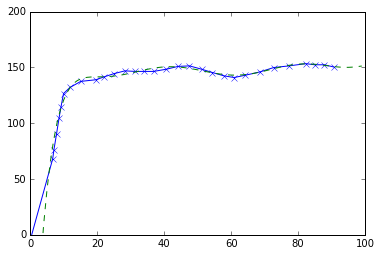

In [56]:
poly_gas = poly1d(polyfit(map(abs, r_v), map(abs, vel), deg=11))
plt.plot(r_v, vel, 'x-')
plt.plot(np.arange(0., 100., 1.), poly_gas(np.arange(0., 100., 1.)), '--')
plt.ylim(0)
plt.xlim(0)

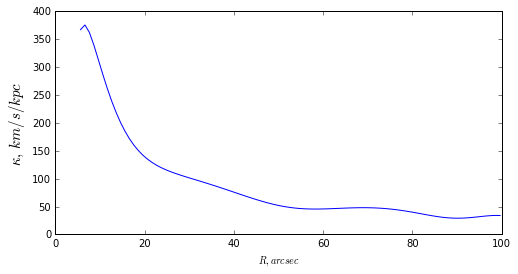

In [57]:
def epicyclicFreq_real(poly_gas, R, resolution):
    '''Честное вычисление эпициклической частоты на расстоянии R.'''
    return sqrt(2.0) * poly_gas(R) * sqrt(1 + R * poly_gas.deriv()(R) / poly_gas(R)) / (R * resolution )

test_points = np.arange(min(np.abs(r_v))+0.1, 100., 1.)

fig = plt.figure(figsize=[8, 4])
plt.plot(test_points, [epicyclicFreq_real(poly_gas, x, 0.072) for x in test_points], '-')
plt.xlabel('$R, arcsec$')
plt.ylabel('$\kappa,\, km/s/kpc$', fontsize=15)
plt.show()

15.0 1.08 194.224356299320 2.85
30.0 2.16 101.331621053555 2.85
45.0 3.24 62.5345986815690 3.17
60.0 4.32 45.6572574172413 4.0
75.0 5.4 45.5591937213943 4.31
90.0 6.48 29.0625059881457 3.23


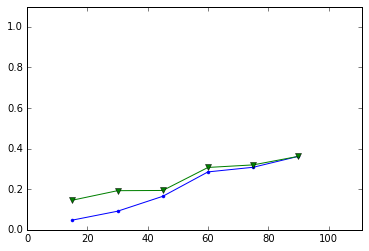

In [58]:
def model_star_dens(r):
    return 550*exp(-r/30.)

Qgs = []
Qss = []
invQeff = []
for r, gd in zip(r_g_dens, gas_dens)[1:-2]:
    print r, r*0.072, epicyclicFreq_real(poly_gas, r, 0.072), gd
    Qgs.append(Qg(epicycl=epicyclicFreq_real(poly_gas, r, 0.072), sound_vel=6., gas_density=gd*1.44))
    Qss.append(Qs(epicycl=epicyclicFreq_real(poly_gas, r, 0.072), sigma=poly_sig(r), star_density=model_star_dens(r)))
    qeff = findInvKinemQeffBrentq(Qss[-1], Qgs[-1], 6./poly_sig(r), np.arange(0.01, 60000., 1.))[1]
    invQeff.append(qeff)
    
plt.plot(r_g_dens[1:-2], map(lambda l: 1./l, Qgs), '.-')
plt.plot(r_g_dens[1:-2], invQeff, 'v-')
plt.ylim(0., 1.1)
plt.xlim(0., 8./0.072)
plt.show()

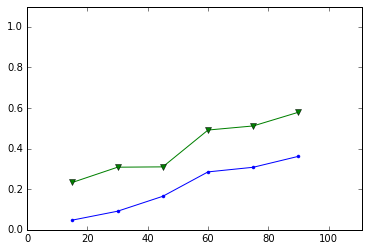

In [60]:
plt.plot(r_g_dens[1:-2], map(lambda l: 1./l, Qgs), '.-')
plt.plot(r_g_dens[1:-2], map(lambda l: 1.6*l, invQeff), 'v-')
plt.ylim(0., 1.1)
plt.xlim(0., 8./0.072)
plt.show()

Вообще не похоже